In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scipy.stats as stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("https://docs.google.com/uc?export=download&id=1INgo03nal-vwFJe7Lec5vOUtOwfJdUr1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
#рассчитаем основные статистики для количественных значений
df[['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']].describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233
std,0.248631,0.171169,1.232592,49.943099,1.460136
min,0.090000,0.360000,2.000000,96.000000,2.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000


In [6]:
# округлим некоторые значения для более репрезентативной моды
dft = df.copy()
dft['satisfaction_level'] = dft['satisfaction_level'].round(1)
dft['last_evaluation'] = dft['last_evaluation'].round(1)

In [7]:
# моду посчитаем так же для порядковых значений
dft.mode().iloc[0]

satisfaction_level         0.8
last_evaluation            0.6
number_project               4
average_montly_hours       135
time_spend_company           3
Work_accident                0
left                         0
promotion_last_5years        0
department               sales
salary                     low
Name: 0, dtype: object

* пока что можно сделать вывод что компания в общем-то неплохая, т.е. из всех сотрудников уровень удовлетворенности колеблется около 0.8 и больше половины находится выше уровня 0.64, в среднем сотрудник проработал 3.5 года и чаще всего не покидал компанию, при этом очевидно что компания требовала от сотрудников явно больше чем платила, т.к. чаще всего работники получали заплату уровня low, не повышались за последние 5 лет и в среднем проводили на работе больше 200 часов в месяц

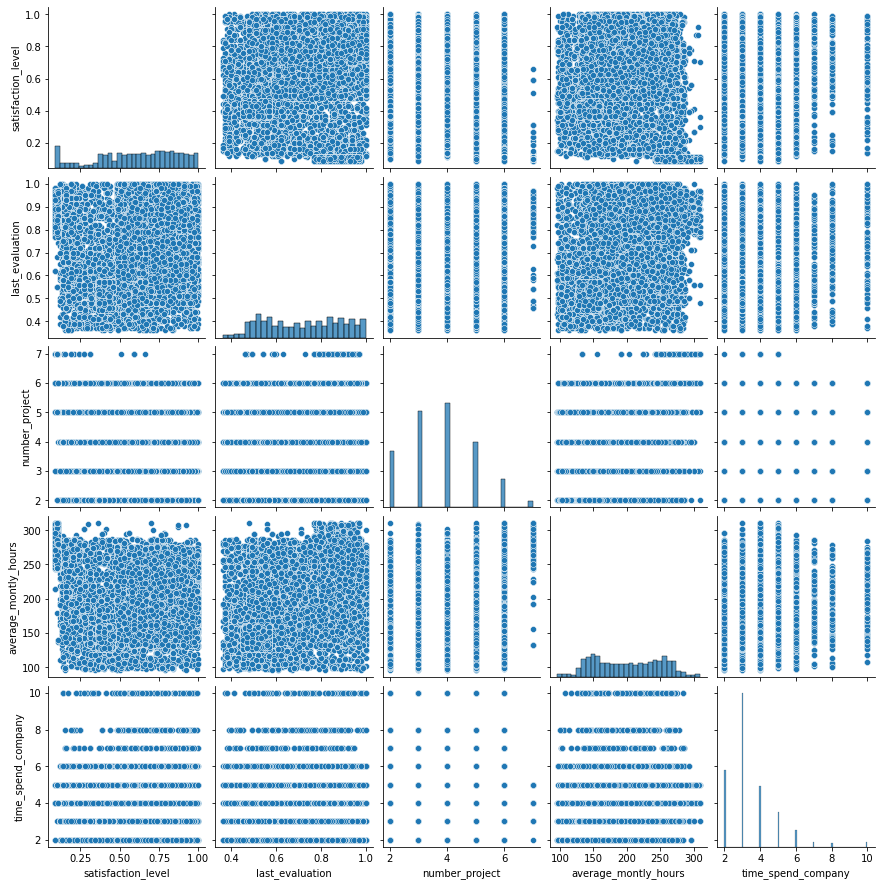

In [8]:
# посмотрим взаимосвязь между признаками
sns.pairplot(df[['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']])

* выглядит не очень, совсем не наглядно

In [9]:
# посчитаем коэффициенты корреляции Пирсона
df[['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']].corr()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000


In [10]:
# возможно Пирсон ошибается, т.к. он очень чувствительный, посчитаем еще Спирмена
df[['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']].corr(method='spearman')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
satisfaction_level,1.000000,0.162407,0.005786,0.062000,-0.139428
last_evaluation,0.162407,1.000000,0.350399,0.342061,0.161154
number_project,0.005786,0.350399,1.000000,0.397855,0.251971
average_montly_hours,0.062000,0.342061,0.397855,1.000000,0.168750
time_spend_company,-0.139428,0.161154,0.251971,0.168750,1.000000


* результаты равнозначны

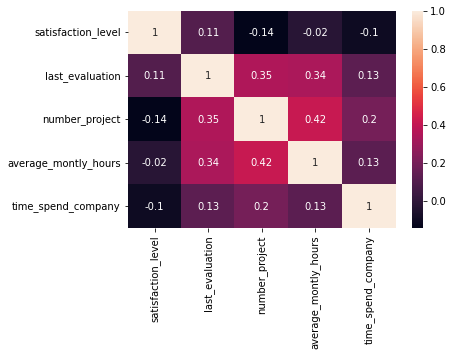

In [11]:
# для наглядности построим тепловую карту
sns.heatmap(df[['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']].corr(), annot=True)

* наибольшей взаимосвязью обладают параметры количество проектов и количество рабочих часов в месяц, интересно что количество проектов не так сильно связаны со стажем работы, наименее взаимосвязанные это уровень удовлетворенности и количество рабочих часов в месяц, что тоже интересно с учетом того что многие люди из компании перерабатывали

In [12]:
#количество сотрудников в каждом департаменте
df_grouped = df.groupby('department').size().sort_values(ascending=True)
print(df_grouped)

department
management      630
hr              739
accounting      767
RandD           787
marketing       858
product_mng     902
IT             1227
support        2229
technical      2720
sales          4140
dtype: int64


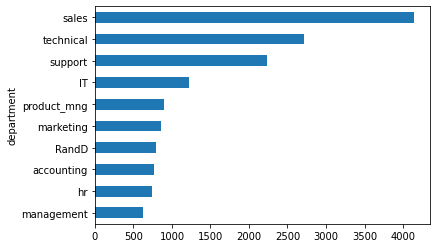

In [13]:
df_grouped.plot(kind='barh')

* компания, скорее всего связана с IT, но большинство людей работало в продажах

In [15]:
#распределение сотрудников по зарплатам
df_grouped2 = df.groupby('salary').size().sort_values(ascending=True)
print(df_grouped2)

salary
high      1237
medium    6446
low       7316
dtype: int64


* видно что большинство получали маленькую заплату

In [16]:
# распределение сотрудников по зарплатам в каждом департаменте
df_grouped3 = df.groupby(['department', 'salary']).size()
print(df_grouped3)

department   salary
IT           high        83
             low        609
             medium     535
RandD        high        51
             low        364
             medium     372
accounting   high        74
             low        358
             medium     335
hr           high        45
             low        335
             medium     359
management   high       225
             low        180
             medium     225
marketing    high        80
             low        402
             medium     376
product_mng  high        68
             low        451
             medium     383
sales        high       269
             low       2099
             medium    1772
support      high       141
             low       1146
             medium     942
technical    high       201
             low       1372
             medium    1147
dtype: int64


In [17]:
# посмотрим тоже самое распределение по зарплатам, но в процентном соотношении
df_grouped4 = round(df_grouped3 / df_grouped3.groupby(level=0).sum()*100,2)
print(df_grouped4)

department   salary
IT           high       6.76
             low       49.63
             medium    43.60
RandD        high       6.48
             low       46.25
             medium    47.27
accounting   high       9.65
             low       46.68
             medium    43.68
hr           high       6.09
             low       45.33
             medium    48.58
management   high      35.71
             low       28.57
             medium    35.71
marketing    high       9.32
             low       46.85
             medium    43.82
product_mng  high       7.54
             low       50.00
             medium    42.46
sales        high       6.50
             low       50.70
             medium    42.80
support      high       6.33
             low       51.41
             medium    42.26
technical    high       7.39
             low       50.44
             medium    42.17
dtype: float64


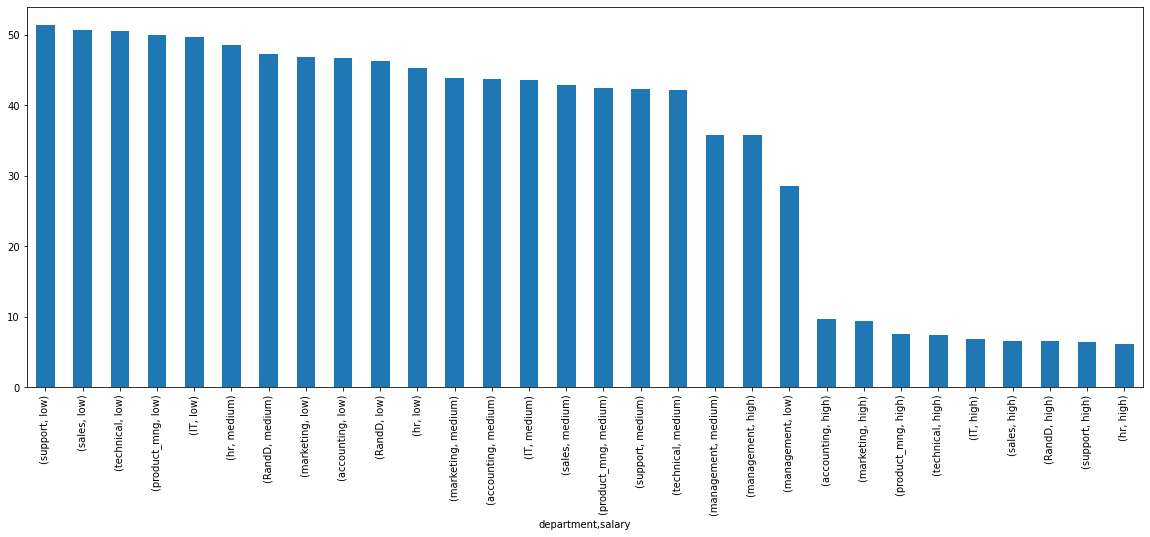

In [18]:
plt.figure(figsize=(20, 7))
df_grouped4.sort_values(ascending=False).plot(kind='bar')
plt.show()

* из такого распределения видно, что распределение по зарплатам внутри департаментов немного разнятся, но все это объяснимо. Наибольшее количество людей с низкими зарплатами в департаментах sales и support

In [19]:
# проверим гипотезу что сотрудники с высоким окладом проводят на работе больше времени, чем сотрудники с низким
df_salary = df.loc[(df.salary == 'low') | (df.salary == 'high')]

In [20]:
df_salary[['salary','average_montly_hours']].groupby('salary').mean()

,average_montly_hours
salary,
high,199.867421
low,200.996583


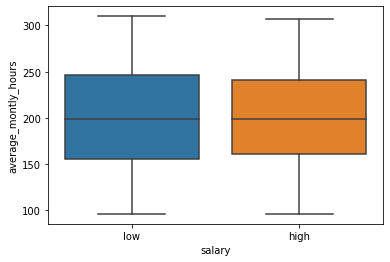

In [21]:
sns.boxplot(x='salary', y='average_montly_hours', data=df_salary)

* пока сказать ничего нельзя, примерно одинаково

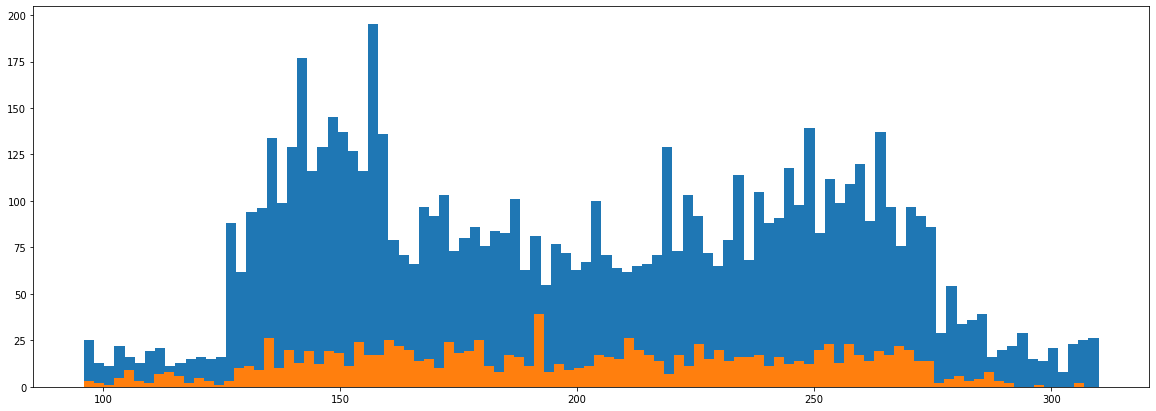

In [22]:
# построим гистограмму
plt.figure(figsize=(20, 7))
plt.hist(df_salary.loc[df_salary.salary == 'low']['average_montly_hours'], bins=100)
plt.hist(df_salary.loc[df.salary == 'high']['average_montly_hours'], bins=100)
plt.show()

* из гистограммы тоже ничего определенно сказать нельзя

In [23]:
# проведем A/B тест с помощью теста Стьюдента
A = df_salary.loc[df_salary.salary == 'low']['average_montly_hours']
B = df_salary.loc[df.salary == 'high']['average_montly_hours']
tvalue, pvalue = stats.ttest_ind(A, B)
print('pvalue: ', pvalue)

pvalue:  0.4661023478267259


* получили высокий p_value на уровне 46%, это означает что выборки не отличаются и нельзя утверждать что сотрудники с высоким окладом проводят на работе больше времени

In [24]:
# разделим выборки на уволившихся и работающих
df_worked = df.loc[df.left == 0]
df_left = df.loc[df.left == 1]

In [25]:
df_worked_promotioned = (df_worked['promotion_last_5years'].loc[df_worked.promotion_last_5years == 1  ].count()/df_worked['promotion_last_5years'].count())*100
df_worked_means = df_worked[['satisfaction_level', 'number_project']].mean()

In [26]:
print('По работающим:')
print('Доля сотрудников с повышением за последние 5 лет: ', round(df_worked_promotioned, 2), '%')
print('Средняя степень удовлетворенности: ', round(df_worked_means.satisfaction_level, 2))
print('Среднее количество проектов: ', round(df_worked_means.number_project, 2))

По работающим:
Доля сотрудников с повышением за последние 5 лет:  2.63 %
Средняя степень удовлетворенности:  0.67
Среднее количество проектов:  3.79


In [27]:
df_left_promotioned = (df_left['promotion_last_5years'].loc[df_left.promotion_last_5years == 1  ].count()/df_left['promotion_last_5years'].count())*100
df_left_means = df_left[['satisfaction_level', 'number_project']].mean()

In [28]:
print('По уволившимся:')
print('Доля сотрудников с повышением за последние 5 лет: ', round(df_left_promotioned, 2), '%')
print('Средняя степень удовлетворенности: ', round(df_left_means.satisfaction_level, 2))
print('Среднее количество проектов: ', round(df_left_means.number_project, 2))

По уволившимся:
Доля сотрудников с повышением за последние 5 лет:  0.53 %
Средняя степень удовлетворенности:  0.44
Среднее количество проектов:  3.86


* можно сделать выводы, что уволившиеся сотрудники были менее довольны работой, им реже повышали оклады и выполняли они большее количество проектов

* решим задачу классификации и построим модель LDA

In [29]:
#разделим выборку на тренировочную и тестовую
dfl = df[['satisfaction_level','last_evaluation', 'number_project','average_montly_hours','time_spend_company','Work_accident','promotion_last_5years']]
X_train, X_test, Y_train, Y_test = train_test_split(dfl, df['left'], test_size=0.3, random_state=21)

In [30]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)


LinearDiscriminantAnalysis()

In [31]:
lda_predicted = lda.predict(X_test)

In [32]:
# проверим качество модели
accuracy_score(Y_test, lda_predicted)

0.7577777777777778

* точность модели 0.75 можно считать хорошей

In [33]:
# т.к. у нас есть и категориальные признаки, построим модель логистической регрессии, возможно она даст результат лучше, но для начала нормализуем данные
scaler = StandardScaler()

In [34]:
dfn = df.copy()
dfn[['satisfaction_level','last_evaluation', 'number_project','average_montly_hours','time_spend_company']] = scaler.fit_transform(dfn[['satisfaction_level','last_evaluation', 'number_project','average_montly_hours','time_spend_company']])

In [35]:
dfln = dfn[['satisfaction_level','last_evaluation', 'number_project','average_montly_hours','time_spend_company','Work_accident','promotion_last_5years']]
X_train_n, X_test_n, Y_train_n, Y_test_n = train_test_split(dfln, dfn['left'], test_size=0.3, random_state=21)

In [36]:
lr = LogisticRegression()
lr.fit(X_train_n, Y_train_n)

LogisticRegression()

In [37]:
lr_predicted = lr.predict(X_test_n)

In [38]:
accuracy_score(Y_test_n, lr_predicted)

0.7615555555555555

* точность немного повысилась, но не сильно, зато мы можем менять какие-то пороговые значения получая вероятности с помощью predict_proba

In [39]:
# для интереса проверим как модель предсказала бы что люди уволятся на выборке уволившихся
dfn_left = dfn.loc[dfn.left == 1]
dfln_left = dfn_left[['satisfaction_level','last_evaluation', 'number_project','average_montly_hours','time_spend_company','Work_accident','promotion_last_5years']]

In [40]:
lr_predicted_left = lr.predict(dfln_left)

In [41]:
accuracy_score(dfn_left['left'], lr_predicted_left)

0.252310277233268

* точность 0.25, модель получилась слабой

In [42]:
lr.predict_proba(dfln_left)

array([[0.55730171, 0.44269829],
       [0.8033201 , 0.1966799 ],
       [0.40935234, 0.59064766],
       ...,
       [0.56258938, 0.43741062],
       [0.31966477, 0.68033523],
       [0.54781552, 0.45218448]])

* хотя по вероятностям видно что они колеблятся возле 50%